In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# 시각화 세팅
plt.rc('axes', labelsize=4, titlesize=14) # unicode_minus=False
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14); plt.rc('ytick', labelsize=14)

In [2]:
from sklearn.datasets import load_sample_images
images = load_sample_images()["images"]
np.array(images).shape

(2, 427, 640, 3)

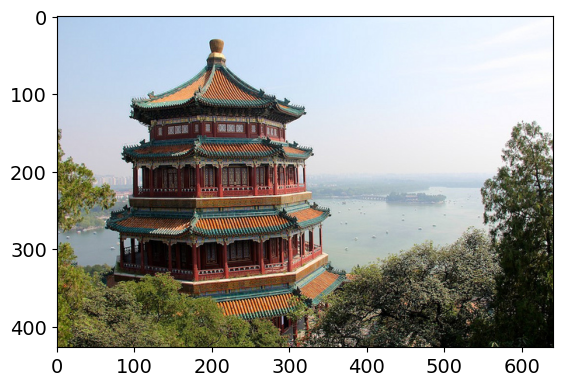

In [4]:
plt.imshow(images[0])

(2, 70, 120, 3)


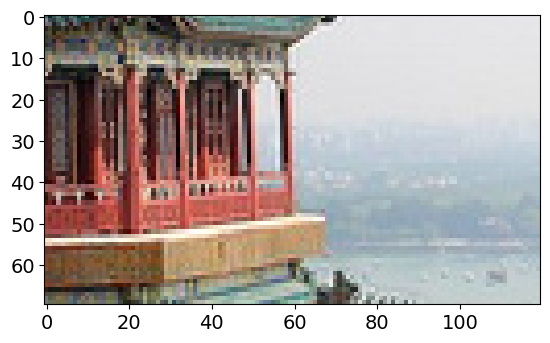

In [9]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)
print(images.shape)
plt.imshow(images[0])

In [13]:
tf.random.set_seed(42)
# [2, 64, 114, 32]
# 스트라이드 1 패딩은 없고... kernel_size-1 한 값으로 shape 해준다.
conv_layers = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layers(images)
fmaps.shape # kernel_size-1 만큼 빼줌

TensorShape([2, 64, 114, 32])

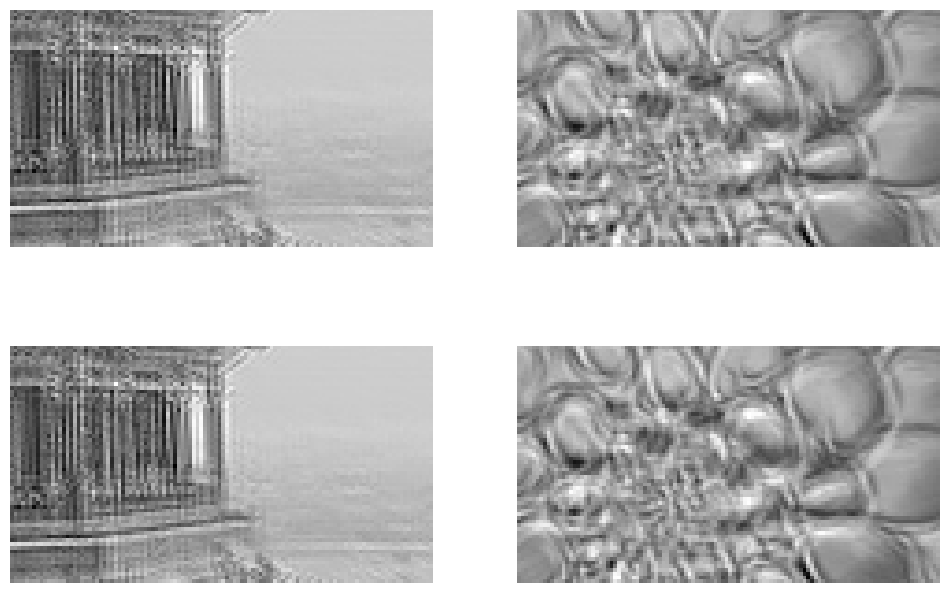

In [17]:
# 채널을 이용해서 채널개수를 늘려주면...conv 학습할 때 다양한 패턴을 학습
plt.figure(figsize=(12, 8))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.imshow(fmaps[i%2,:,:,i%2],cmap='gray_r')
  plt.axis('off')
plt.show()

In [18]:
# 패딩...제로패딩 스트라이드가 1이면 크기 변동 없음
conv_layers = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same') # 제로패딩
fmaps = conv_layers(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [22]:
# padding='same' 이면 스트라이드로 나눈다. 나눠지지 않으면 나머지가 0이 되도록 연산
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same',strides=2) # 제로페딩 추가
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [23]:
# 패딩이 valid 여부에 따라서 shape 형태가 달라진다.
def conv_output_size(input_size, kernel_size, stride=1, padding='valid'):
  if padding == 'valid':
    z = input_size - kernel_size  + 1
    output_size = z // stride
    num_ignored = z%stride
    return output_size, num_ignored
  else:
    output_size = (input_size -1) // stride + 1
    num_padded = (output_size - 1) * stride - input_size + kernel_size
    return output_size, num_padded
conv_output_size(np.array([70,120]),kernel_size = 7, stride=2, padding='same')

(array([35, 60]), array([5, 5]))

In [24]:
# 가중치 7, 7, 3, 32 --> 7,7 필터의 크기, 3 입력 데이터의 채널수, 32 필터의 개수
kernels, bias = conv_layer.weights
kernels, bias

(<KerasVariable shape=(7, 7, 3, 32), dtype=float32, path=conv2d_4/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=conv2d_4/bias>)

In [25]:
# 폴링 - 케라스로 구현

In [42]:
# max_pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2) # 최대
max_pool = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2) # 평균
output = max_pool(images)
print(images.shape)

(2, 70, 120, 3)


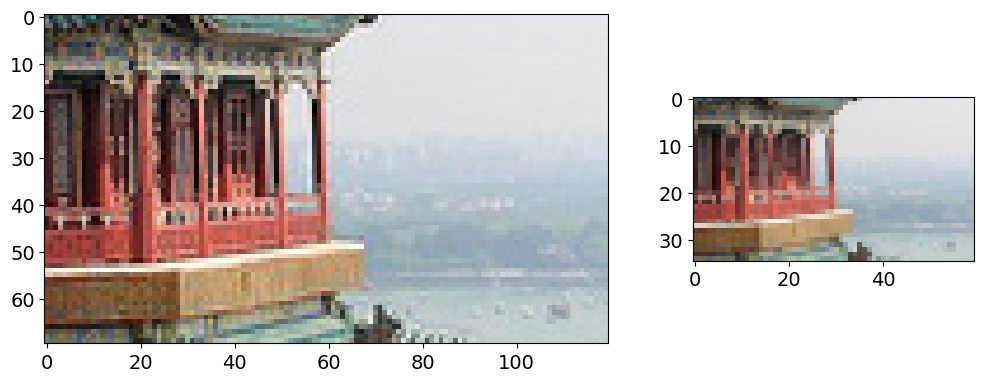

In [43]:
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(1,2,width_ratios=(2,1))
fig.add_subplot(gs[0])
plt.imshow(images[0])
fig.add_subplot(gs[1])
plt.imshow(output[0])
plt.show()

In [44]:
# CNN
# mnist 분류기

In [48]:
(x_train_f, y_train_f),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_f.shape
# 채널 정보를 추가하고 그리고 정규화
x_train_f = np.expand_dims(x_train_f,axis=-1) / 255. # 차수 정보 추가
x_test = np.expand_dims(x_test,axis=-1) / 255.
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_f, y_train_f, test_size=0.1)
x_train.shape, x_valid.shape

((54000, 28, 28, 1), (6000, 28, 28, 1))

In [51]:
# 재현성을 보장 : 랜덤시드를 고정시켜서 데이터의 변화에 따른 성능 변화를 금지시켜서 오로지 모델선택에 관해 일관성을 유지하는 방법
tf.random.set_seed(42)

In [55]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu')
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=x_train.shape[1:]), # [28,28,1]
    tf.keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPooling2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))
scores = model.evaluate(x_test, y_test)
# 예측
x_new = x_test[:10]
y_pred = model.predict(x_new)

Epoch 1/10
 103/1688 ━━━━━━━━━━━━━━━━━━━━ 11:51 449ms/step - accuracy: 0.1259 - loss: 2.2703